# Voice Data Detects Disease


The data that we will be looking at was collected in a study. The study recruited adult subjects ranging from 18 to 70 years old who were capable of engaging in the research's required stages. Exclusion criteria included minors and individuals over 70, those with vocal fold disorders, upper respiratory tract infections, or neurological issues. Recordings were sampled at 8000 Hz with a 32-bit resolution and underwent noise-filtering to ensure clarity. Subjects were instructed to speak at a regular conversational volume and underwent several practice attempts prior to the final recording.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
#wfdb is the package that can read WFDB format file
import wfdb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

We need to read the information text files first associated with all 208 subjects


In [2]:
def read_info_file(file_path):
    data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
    for line in lines:
        line = line.strip()
        if line:
            if ':' not in line:  # Check if the line contains a colon
                continue  # If not, skip this line
            key, value = line.split(':', 1)  # Split only on the first colon
            key = key.strip()
            value = value.strip()
            if value.lower() == 'nu' or not value:  # Check for 'NU' or empty string
                value = np.nan  # Replace 'NU' with NaN
            else:
                try:
                    # Remove units and convert to float
                    value = float(value.replace('gr', '').replace('litres', '').replace(',', '.'))
                except ValueError:
                    pass  # Keep as string if not a number
            data[key] = value
    return data


The voice recordings are provided in WFDB format. Each of the 208 subjects have a 
.dat file associated with them. This is the voice recording data, in order to read this data we have to use the wfdb package


In [3]:
def read_signal_files(dat_file_path, hea_file_path):
    # Load the record using wfdb
    record = wfdb.rdrecord(dat_file_path.replace('.dat', ''))
    
    # Extract the signal and annotations from the record
    signal = record.p_signal.flatten()  # Assuming it's a single-channel recording
    
    # Calculate basic statistics on the signal
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    max_signal = np.max(signal)
    min_signal = np.min(signal)
    
    # Create a dictionary with the extracted data
    signal_data = {
        'Mean_Signal': mean_signal,
        'Std_Signal': std_signal,
        'Max_Signal': max_signal,
        'Min_Signal': min_signal
    }
    
    return signal_data

Implement a loop to start reading all the files for the 208 subjects within the databse


In [4]:
# Base path to the voice-database folder
base_path = 'voice-database'

# Initialize a list to hold all combined subject data
all_subject_data = []

# Loop over all subject IDs
for subject_id in range(1, 209):  # Assuming IDs from 001 to 208
    # Construct file paths
    info_path = os.path.join(base_path, f'voice{subject_id:03}-info.txt')
    dat_path = os.path.join(base_path, f'voice{subject_id:03}.dat')
    hea_path = os.path.join(base_path, f'voice{subject_id:03}.hea')
    txt_path = os.path.join(base_path, f'voice{subject_id:03}.txt')
    
    # Read and process info file
    info_data = read_info_file(info_path)
    
    # Read and process signal files (.dat and .hea)
    signal_data = read_signal_files(dat_path, hea_path)
    
    # Combine the info and signal data into one record
    combined_data = info_data.copy()
    combined_data.update(signal_data) 
    
    # Append the combined data to the list
    all_subject_data.append(combined_data)

# Convert the list to a DataFrame
all_subjects_df = pd.DataFrame(all_subject_data)


**Exploring the Dataframe we have crated.**

Use the .head() funtion to display the first few rows of the DataFrame.


In [5]:
all_subjects_df.head()

,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,Amount of water's litres drink every day,...,Carbonated beverages,Tomatoes,Coffee,Chocolate,Soft cheese,Citrus fruits,Mean_Signal,Std_Signal,Max_Signal,Min_Signal
0,32.0,m,hyperkinetic dysphonia,Researcher,15.0,5.0,no,NaN,casual drinker,1.5,...,almost never,sometimes,almost always,almost never,sometimes,sometimes,-0.000478,0.130235,0.590118,-0.462646
1,55.0,m,healthy,Employee,17.0,12.0,casual smoker,2.0,habitual drinker,0.5,...,almost always,sometimes,sometimes,sometimes,almost always,almost always,-0.000198,0.290999,0.906860,-0.872040
2,34.0,m,hyperkinetic dysphonia (nodule),Researcher,42.0,26.0,no,NaN,casual drinker,1.5,...,sometimes,sometimes,almost always,sometimes,almost always,almost never,-0.000311,0.259768,0.925568,-0.756714
3,28.0,f,hypokinetic dysphonia,Researcher,20.0,9.0,casual smoker,NaN,casual drinker,1.0,...,almost never,sometimes,always,sometimes,almost always,sometimes,-0.000523,0.051166,0.185791,-0.151184
4,54.0,f,hypokinetic dysphonia,Researcher,39.0,23.0,no,NaN,casual drinker,1.5,...,never,sometimes,never,sometimes,sometimes,almost always,-0.000494,0.185828,0.586456,-0.534973


Use the .info() function with the dataframe. This will provide a concise summary of the DataFrame, including the number of non-null entries in each column and data types.


In [6]:
all_subjects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       208 non-null    float64
 1   Gender                                    208 non-null    object 
 2   Diagnosis                                 208 non-null    object 
 3   Occupation status                         167 non-null    object 
 4   Voice Handicap Index (VHI) Score          208 non-null    float64
 5   Reflux Symptom Index (RSI) Score          208 non-null    float64
 6   Smoker                                    208 non-null    object 
 7   Number of cigarettes smoked per day       41 non-null     float64
 8   Alcohol consumption                       208 non-null    object 
 9   Amount of water's litres drink every day  208 non-null    float64
 10  Eating habits                         

After using the .info() function we can see that the Dataframe has eating habits, however by a simple look at the subject data info.txt files we can see that they don't have anything for that section. So we should remove this from our dataset.

In [7]:
all_subjects_df = all_subjects_df.drop(columns=['Eating habits'])

Use the .describe() function with the Dataframe. This gives a statistical summary of the DataFrame, useful for numerical fields.


In [8]:
# Drop the 'count' row from the resulting DataFrame this will make it now show when we use the describe function 
all_subjects_df.describe().drop('count')

,Age,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Number of cigarettes smoked per day,Amount of water's litres drink every day,Mean_Signal,Std_Signal,Max_Signal,Min_Signal
mean,44.086538,23.846154,11.990385,15.292683,1.431490,-0.000397,0.196733,0.740366,-0.573302
std,13.743763,23.588366,8.302837,8.629148,0.471206,0.000103,0.070158,0.210519,0.213895
min,18.000000,0.000000,0.000000,2.000000,0.250000,-0.000615,0.038769,0.117798,-1.000000
25%,32.750000,5.000000,5.000000,10.000000,1.000000,-0.000477,0.150141,0.609100,-0.746819
50%,45.000000,17.000000,12.000000,15.000000,1.500000,-0.000416,0.195999,0.782242,-0.575638
75%,55.000000,35.000000,18.000000,20.000000,2.000000,-0.000326,0.252970,0.918266,-0.421722
max,70.000000,106.000000,41.000000,40.000000,2.500000,-0.000111,0.348097,0.999969,-0.102875


We wanna find out how many features our dataframe has so let's use .shape function. 

In [9]:
num_features = all_subjects_df.shape[1]
print(f"Number of features: {num_features}")

Number of features: 20


Let's revisit our function read_signal_files that reads the voice recordinds of the 208 subjects in our dataset. Why do we store 4 things(Mean Signal, Standar Deviation of Signal, Max Signal, and Minimum Signal) for each of the 208 subjects? Let's look at these more in detail. 

*Mean Signal:* The mean signal represents the average amplitude of the voice recording. It can provide insights into the overall loudness and energy of the voice sample. Variations in the mean signal can be indicative of vocal health, where unusually high or low average amplitudes may suggest possible voice disorders.

*Standard Deviation of Signal:* This measures the amount of variation or dispersion from the mean signal. A high standard deviation indicates that the signal varies widely from the mean, which could be a sign of an unstable or inconsistent voice — potentially a symptom of a voice pathology.

*Maximum Signal Amplitude:* The maximum amplitude reflects the loudest part of the voice recording. By identifying the peak amplitude, we can assess the dynamic range of the subject's voice and detect any abnormal vocal efforts or strain.

*Minimum Signal Amplitude:* Conversely, the minimum amplitude can indicate the softest part of the recording. Analyzing both the maximum and minimum amplitudes can give us a better understanding of the subject's vocal range and any difficulties in maintaining vocal intensity.

Lets split our data into training and test sets. We will also change the diagnosis feature to be numeric instead. So diagnosis will now only be 0 or 1. With 0 representing a healthy subject, while 1 will represent a subject with a disease.

In [10]:
from sklearn.model_selection import train_test_split
# Select only the voice data features for X
voice_features = ['Mean_Signal', 'Std_Signal', 'Max_Signal', 'Min_Signal']
X = all_subjects_df[voice_features]

# We wanna mark the diagnosis as numbers. 0 = healthy, and if they have any other disease it will be 1
all_subjects_df['Diagnosis'] = all_subjects_df['Diagnosis'].str.lower().str.strip().apply(lambda x: 0 if x == 'healthy' else 1)

# The target variable is Diagnosis since that's what we will be focusing on 
y = all_subjects_df['Diagnosis']

# Splitting the data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Let's visualize if there is a trend between 'Mean_Signal' and 'Diagnosis. Let's do a scatterplot for this.

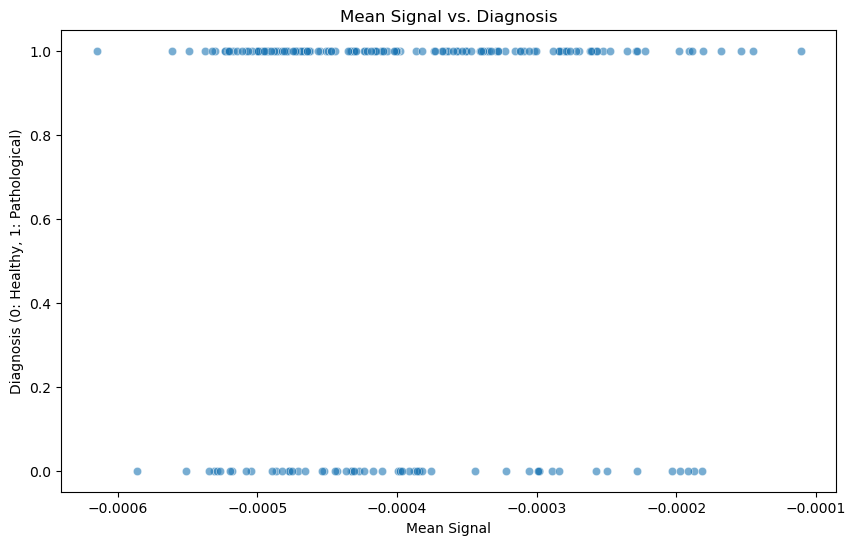

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mean_Signal', y='Diagnosis', data=all_subjects_df, alpha=0.6)
plt.title('Mean Signal vs. Diagnosis')
plt.xlabel('Mean Signal')
plt.ylabel('Diagnosis (0: Healthy, 1: Pathological)')
plt.show()

0.6825396825396826 [[ 6 15]
 [ 5 37]]


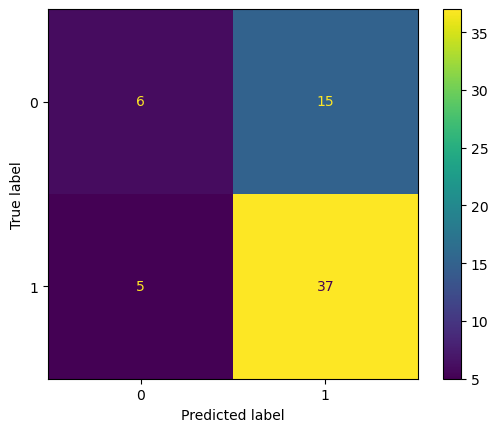

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay


knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(accuracy, conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.show()

Another model that we will use is the Random Forest Classifier

Accuracy of the Random Forest classifier: 0.67


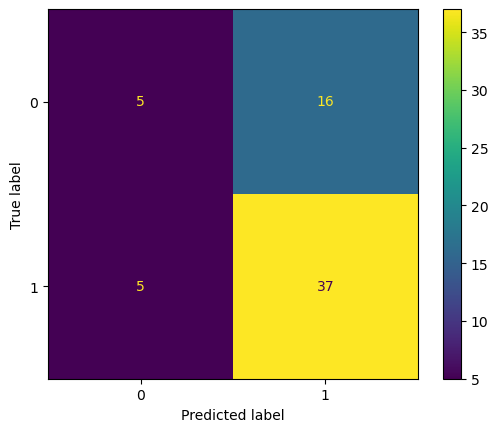

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=10)

# Train the model 
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)


# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the Random Forest classifier: {accuracy:.2f}')

conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.show()